<a href="https://colab.research.google.com/github/dzthai/CS5787_SwiftEdit2_Fashion/blob/main/Milestone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Development outline

# 1. Get SwiftEdit2 working (4.1)
# 2. Prepare / store data (David)
    # need to get (4.4) (image, text edit, output image) probably from deepFashion dataset
# 3. Train model (Sona)
# 4. Evaluate model

# Later: Domain specific edits and LoRA Adapters
# Writing outline
# 1.

In [7]:
# Cell 1: Reset working directory and install packages
import os
os.chdir('/content')  # Go to a safe directory
!pip install datasets pillow pandas matplotlib -q

In [13]:
"""
MagicBrush Fashion Filter - Controlled Loading
Uses datasets library but extracts text FIRST before images are cached
"""

import json
from collections import Counter
import pandas as pd
import os

class MagicBrushFashionLoader:
    def __init__(self):
        """
        Initialize the MagicBrush loader
        """
        # Fashion-related keywords - EXPANDED LIST
        self.fashion_keywords = [
            # Clothing items
            'dress', 'shirt', 'pants', 'jeans', 'coat', 'jacket',
            'skirt', 'blouse', 'sweater', 'hoodie', 'clothing',
            'fashion', 'wear', 'outfit', 'suit', 'tie', 'shoes',
            'boots', 'sneakers', 'hat', 'scarf', 'gloves', 'socks',
            'shorts', 'tank top', 't-shirt', 'blazer', 'cardigan',
            'uniform', 'robe', 'gown', 'vest', 'sleeve', 'collar',
            'garment', 'attire', 'clothes',

            # Materials and patterns
            'button', 'zipper', 'pocket', 'fabric', 'textile',
            'cotton', 'silk', 'denim', 'leather', 'wool',
            'sleeves', 'neckline', 'hem', 'belt', 'stripe',
            'pattern', 'polka dot', 'plaid', 'checkered',

            # Actions that might relate to clothing
            'wear', 'wearing', 'worn', 'dressed'
        ]

    def load_text_only_streaming(self, max_samples=1000):
        """
        Load only text fields using streaming - images never cached

        Args:
            max_samples: Max samples to check

        Returns:
            list: Samples with text only
        """
        print("="*60)
        print("LOADING MAGICBRUSH TEXT METADATA")
        print("="*60)
        print(f"⚡ Streaming mode - checking first {max_samples} samples")
        print("✓ Images will NOT be downloaded")
        print()

        try:
            from datasets import load_dataset

            # Critical: Use streaming=True and IMMEDIATELY extract text
            print("📥 Connecting to HuggingFace (streaming mode)...")
            dataset = load_dataset(
                "osunlp/MagicBrush",
                split='train',
                streaming=True  # This prevents bulk download
            )

            samples = []
            print("📝 Extracting text metadata only...")

            for idx, item in enumerate(dataset):
                if idx >= max_samples:
                    break

                # Extract ONLY text fields - don't touch image fields
                samples.append({
                    'id': f"train_{idx}",
                    'img_id': item.get('img_id', ''),
                    'turn_index': item.get('turn_index', 0),
                    'instruction': item.get('instruction', ''),
                    'source_file': item.get('source_file', ''),
                    'target_file': item.get('target_file', ''),
                    'split': 'train'
                })

                if (idx + 1) % 100 == 0:
                    print(f"   ✓ Processed {idx + 1} samples...")

            print(f"\n✓ Loaded {len(samples)} text records")
            print(f"✓ Memory usage: ~{len(json.dumps(samples)) / 1024:.1f} KB")

            return samples

        except ImportError:
            print("❌ Please install: pip install datasets")
            return None
        except Exception as e:
            print(f"❌ Error: {e}")
            return None

    def is_fashion_related(self, text):
        """
        Check if instruction text is fashion-related

        Args:
            text: Instruction text to check

        Returns:
            bool: True if fashion-related
        """
        if not text:
            return False
        text_lower = text.lower()
        return any(keyword in text_lower for keyword in self.fashion_keywords)

    def filter_fashion_samples(self, samples):
        """
        Filter samples for fashion-related content

        Args:
            samples: List of samples

        Returns:
            list: Filtered fashion samples
        """
        print("\n🔍 Filtering for fashion-related instructions...")
        fashion_samples = [s for s in samples if self.is_fashion_related(s['instruction'])]
        print(f"✓ Found {len(fashion_samples)} fashion samples")

        if len(samples) > 0:
            print(f"   ({len(fashion_samples)/len(samples)*100:.1f}% of total)")

        return fashion_samples

    def analyze_fashion_data(self, fashion_samples, all_samples):
        """
        Analyze the filtered fashion dataset

        Args:
            fashion_samples: List of fashion samples
            all_samples: All samples for comparison

        Returns:
            dict: Statistics
        """
        print("\n" + "="*60)
        print("FASHION DATASET ANALYSIS")
        print("="*60)

        total_fashion = len(fashion_samples)
        total_all = len(all_samples)

        print(f"\n📊 Results:")
        print(f"   Total samples checked: {total_all}")
        print(f"   Fashion samples found: {total_fashion}")
        print(f"   Fashion ratio: {total_fashion/total_all*100:.1f}%")

        if total_fashion == 0:
            print("\n⚠️  No fashion samples found!")
            print("\n💡 This could mean:")
            print("   1. Keywords are too strict")
            print("   2. MagicBrush isn't fashion-focused")
            print("   3. Need to inspect actual instructions")

            # Show sample instructions for debugging
            print("\n📝 Sample instructions from dataset:")
            for i, sample in enumerate(all_samples[:10]):
                print(f"   {i+1}. \"{sample['instruction']}\"")

            return {'total_samples': 0}

        # Turn distribution
        turns = Counter([s.get('turn_index', 0) for s in fashion_samples])
        print(f"\n🔄 Turn Distribution:")
        for turn, count in sorted(turns.items()):
            print(f"   Turn {turn}: {count} samples")

        # Instruction analysis
        instructions = [s['instruction'] for s in fashion_samples if s['instruction']]
        avg_length = sum(len(inst.split()) for inst in instructions) / len(instructions)

        print(f"\n📝 Instruction Stats:")
        print(f"   Average length: {avg_length:.1f} words")

        # Keyword frequency
        keyword_counts = Counter()
        for sample in fashion_samples:
            text = sample['instruction'].lower() if sample['instruction'] else ''
            for keyword in self.fashion_keywords:
                if keyword in text:
                    keyword_counts[keyword] += 1

        print(f"\n🏷️  Top 10 Fashion Keywords Found:")
        for keyword, count in keyword_counts.most_common(10):
            print(f"   '{keyword}': {count} times")

        # Sample instructions
        print(f"\n💬 Fashion Instruction Examples:")
        for i, sample in enumerate(fashion_samples[:15]):
            inst = sample['instruction']
            display = inst if len(inst) <= 70 else inst[:70] + "..."
            print(f"   {i+1}. \"{display}\"")

        stats = {
            'total_samples': total_fashion,
            'total_checked': total_all,
            'fashion_ratio': total_fashion/total_all if total_all > 0 else 0,
            'turns': dict(turns),
            'top_keywords': keyword_counts.most_common(10)
        }

        return stats

    def save_outputs(self, fashion_samples, all_samples):
        """
        Save both fashion and all samples for inspection

        Args:
            fashion_samples: Filtered fashion samples
            all_samples: All samples
        """
        print("\n💾 Saving outputs...")

        # Save fashion samples
        if len(fashion_samples) > 0:
            with open('fashion_samples.json', 'w') as f:
                json.dump(fashion_samples, f, indent=2)

            df_fashion = pd.DataFrame(fashion_samples)
            df_fashion.to_csv('fashion_samples.csv', index=False)

            print(f"✓ fashion_samples.json ({len(fashion_samples)} samples)")
            print(f"✓ fashion_samples.csv")

        # Save all samples for manual inspection
        df_all = pd.DataFrame(all_samples)
        df_all.to_csv('all_samples.csv', index=False)
        print(f"✓ all_samples.csv ({len(all_samples)} samples)")
        print("\n💡 Open all_samples.csv to manually find fashion examples")


def main():
    """
    Main execution
    """
    print("="*60)
    print("MAGICBRUSH FASHION FILTER")
    print("Streaming Mode - Text Only")
    print("="*60)
    print("\n⚠️  Note: We'll check first 1000 samples only")
    print("   (To avoid downloading entire dataset)")
    print()

    # Check disk space before starting
    import shutil
    disk = shutil.disk_usage('/content')
    free_gb = disk.free / (1024**3)
    print(f"💾 Free disk space: {free_gb:.1f} GB")

    if free_gb < 5:
        print("⚠️  Warning: Low disk space!")
        print("   This should still work (text only)")

    print()

    # Initialize
    loader = MagicBrushFashionLoader()

    # Load text metadata only
    all_samples = loader.load_text_only_streaming(max_samples=3000)

    if not all_samples or len(all_samples) == 0:
        print("\n❌ Failed to load data")
        return None, None

    # Filter for fashion
    fashion_samples = loader.filter_fashion_samples(all_samples)

    # Analyze
    stats = loader.analyze_fashion_data(fashion_samples, all_samples)

    # Save outputs
    loader.save_outputs(fashion_samples, all_samples)

    # Final verdict
    print("\n" + "="*60)
    print("VERDICT & NEXT STEPS")
    print("="*60)

    if stats['total_samples'] == 0:
        print("\n❌ MagicBrush has NO/FEW fashion samples")
        print("\n📋 Action Plan:")
        print("   1. Open 'all_samples.csv' and manually check instructions")
        print("   2. If you find fashion examples, tell me the keywords used")
        print("   3. Most likely: Use DeepFashion2 with synthetic prompts instead")
    elif stats['total_samples'] < 100:
        print(f"\n⚠️  Only {stats['total_samples']} fashion samples found")
        print("\n📋 Action Plan:")
        print("   1. Use these for preliminary results")
        print("   2. MUST augment with DeepFashion2 for final project")
        print("   3. Check 'fashion_samples.csv' to verify quality")
    else:
        print(f"\n✓ Found {stats['total_samples']} fashion samples!")
        print("\n📋 Next Steps:")
        print("   1. Review 'fashion_samples.csv'")
        print("   2. Use for preliminary results")
        print("   3. Optionally augment with more data later")

    # Check disk usage
    print()
    disk = shutil.disk_usage('/content')
    used_mb = (disk.total - disk.free) / (1024**2)
    print(f"💾 Current disk usage: {used_mb:.0f} MB")

    return fashion_samples, stats


if __name__ == "__main__":
    print("Required: pip install datasets pandas")
    print("\n")

    fashion_samples, stats = main()

Required: pip install datasets pandas


MAGICBRUSH FASHION FILTER
Streaming Mode - Text Only

⚠️  Note: We'll check first 1000 samples only
   (To avoid downloading entire dataset)

💾 Free disk space: 68.6 GB

LOADING MAGICBRUSH TEXT METADATA
⚡ Streaming mode - checking first 3000 samples
✓ Images will NOT be downloaded

📥 Connecting to HuggingFace (streaming mode)...


Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

📝 Extracting text metadata only...
   ✓ Processed 100 samples...
   ✓ Processed 200 samples...
   ✓ Processed 300 samples...
   ✓ Processed 400 samples...
   ✓ Processed 500 samples...
   ✓ Processed 600 samples...
   ✓ Processed 700 samples...
   ✓ Processed 800 samples...
   ✓ Processed 900 samples...
   ✓ Processed 1000 samples...
   ✓ Processed 1100 samples...
   ✓ Processed 1200 samples...
   ✓ Processed 1300 samples...
   ✓ Processed 1400 samples...
   ✓ Processed 1500 samples...
   ✓ Processed 1600 samples...
   ✓ Processed 1700 samples...
   ✓ Processed 1800 samples...
   ✓ Processed 1900 samples...
   ✓ Processed 2000 samples...
   ✓ Processed 2100 samples...
   ✓ Processed 2200 samples...
   ✓ Processed 2300 samples...
   ✓ Processed 2400 samples...
   ✓ Processed 2500 samples...
   ✓ Processed 2600 samples...
   ✓ Processed 2700 samples...
   ✓ Processed 2800 samples...
   ✓ Processed 2900 samples...
   ✓ Processed 3000 samples...

✓ Loaded 3000 text records
✓ Memory usage: 

In [16]:
df = pd.read_csv('fashion_samples.csv')
df.head()

316

MAGICBRUSH FASHION VISUALIZER

Options:
1. visualize_fashion_samples(5)  - View first 5 samples
2. visualize_specific_samples([0, 10, 20, 30, 40])  - View specific indices

Default: Visualizing first 5 samples...

MAGICBRUSH FASHION SAMPLE VISUALIZER

📂 Loading fashion samples metadata...
✓ Loaded 316 fashion samples

📥 Downloading images for 5 samples...
⚠️  This will download ~2-5 MB
   Loading full dataset (this may take a moment)...


Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

data/train-00000-of-00051-9fd9f23e2b1cb3(…):   0%|          | 0.00/506M [00:00<?, ?B/s]

data/train-00001-of-00051-7fc041c6c75c7a(…):   0%|          | 0.00/493M [00:00<?, ?B/s]

data/train-00002-of-00051-4683be833ed06f(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00003-of-00051-dbbf01b8d47907(…):   0%|          | 0.00/533M [00:00<?, ?B/s]

data/train-00004-of-00051-d373bd832c3222(…):   0%|          | 0.00/491M [00:00<?, ?B/s]

data/train-00005-of-00051-261c379dee1873(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

data/train-00006-of-00051-1601e4998b8705(…):   0%|          | 0.00/494M [00:00<?, ?B/s]

data/train-00007-of-00051-09790524710489(…):   0%|          | 0.00/505M [00:00<?, ?B/s]

data/train-00008-of-00051-45475d9537033a(…):   0%|          | 0.00/528M [00:00<?, ?B/s]

data/train-00009-of-00051-cf6ff6a53b3552(…):   0%|          | 0.00/512M [00:00<?, ?B/s]

data/train-00010-of-00051-d73c61985d7081(…):   0%|          | 0.00/522M [00:00<?, ?B/s]

data/train-00011-of-00051-8b4c59c53a36a8(…):   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00012-of-00051-7a326334a53d22(…):   0%|          | 0.00/500M [00:00<?, ?B/s]

data/train-00013-of-00051-7a32a843bae55f(…):   0%|          | 0.00/494M [00:00<?, ?B/s]

data/train-00014-of-00051-34fbf4e78f18f5(…):   0%|          | 0.00/499M [00:00<?, ?B/s]

data/train-00015-of-00051-b0616f1aa69cc3(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

data/train-00016-of-00051-2ce592a2aa4c0b(…):   0%|          | 0.00/519M [00:00<?, ?B/s]

data/train-00017-of-00051-29b16824f54f17(…):   0%|          | 0.00/504M [00:00<?, ?B/s]

data/train-00018-of-00051-b8a3cc2bebe485(…):   0%|          | 0.00/491M [00:00<?, ?B/s]

data/train-00019-of-00051-7496aa939d5aaf(…):   0%|          | 0.00/530M [00:00<?, ?B/s]

data/train-00020-of-00051-0e4f76bd7de39d(…):   0%|          | 0.00/520M [00:00<?, ?B/s]

data/train-00021-of-00051-aea46908b3d257(…):   0%|          | 0.00/492M [00:00<?, ?B/s]

data/train-00022-of-00051-3a7846cdc795c3(…):   0%|          | 0.00/511M [00:00<?, ?B/s]

data/train-00023-of-00051-581ce36816474c(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00024-of-00051-63f85f8694db99(…):   0%|          | 0.00/509M [00:00<?, ?B/s]

data/train-00025-of-00051-eb6b4b387abb3b(…):   0%|          | 0.00/500M [00:00<?, ?B/s]

data/train-00026-of-00051-a37258445ad77c(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

data/train-00027-of-00051-0c3caef58833e3(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00028-of-00051-a864102cdd7e0d(…):   0%|          | 0.00/519M [00:00<?, ?B/s]

data/train-00029-of-00051-d4b5816a0785e2(…):   0%|          | 0.00/493M [00:00<?, ?B/s]

data/train-00030-of-00051-d57316916f4cce(…):   0%|          | 0.00/511M [00:00<?, ?B/s]

data/train-00031-of-00051-baa9fa3e29dfb8(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00032-of-00051-cfc5f479ca5625(…):   0%|          | 0.00/515M [00:00<?, ?B/s]

data/train-00033-of-00051-80e659de48bfed(…):   0%|          | 0.00/515M [00:00<?, ?B/s]

data/train-00034-of-00051-d5a8a32783d7b7(…):   0%|          | 0.00/500M [00:00<?, ?B/s]

data/train-00035-of-00051-6df799054d7c06(…):   0%|          | 0.00/492M [00:00<?, ?B/s]

data/train-00036-of-00051-3c85ce9e4996c7(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00037-of-00051-24003f9a1733a2(…):   0%|          | 0.00/501M [00:00<?, ?B/s]

data/train-00038-of-00051-a035b244c8b6e2(…):   0%|          | 0.00/494M [00:00<?, ?B/s]

data/train-00039-of-00051-0a94fb0d0e1e35(…):   0%|          | 0.00/508M [00:00<?, ?B/s]

data/train-00040-of-00051-3770c96bedf6c3(…):   0%|          | 0.00/499M [00:00<?, ?B/s]

data/train-00041-of-00051-45bf2e58112437(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00042-of-00051-494734a9b0704e(…):   0%|          | 0.00/506M [00:00<?, ?B/s]

data/train-00043-of-00051-340358803f3655(…):   0%|          | 0.00/485M [00:00<?, ?B/s]

data/train-00044-of-00051-12cc4bb9cdfcfd(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

data/train-00045-of-00051-ac7a4fc63484f5(…):   0%|          | 0.00/495M [00:00<?, ?B/s]

data/train-00046-of-00051-caf11c5fbe9bb1(…):   0%|          | 0.00/523M [00:00<?, ?B/s]

data/train-00047-of-00051-a99476a212efcb(…):   0%|          | 0.00/494M [00:00<?, ?B/s]

data/train-00048-of-00051-9aa83b8e4abb3e(…):   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00049-of-00051-e24aa47c28573c(…):   0%|          | 0.00/514M [00:00<?, ?B/s]

data/train-00050-of-00051-7a5506bb37822b(…):   0%|          | 0.00/500M [00:00<?, ?B/s]

data/dev-00000-of-00004-f147d414270a90e1(…):   0%|          | 0.00/387M [00:00<?, ?B/s]

data/dev-00001-of-00004-8ef3de1dc8cb8a6a(…):   0%|          | 0.00/380M [00:00<?, ?B/s]

data/dev-00002-of-00004-54c4d7b0a9e49db5(…):   0%|          | 0.00/374M [00:00<?, ?B/s]

data/dev-00003-of-00004-384b81a61c93b7e3(…):   0%|          | 0.00/380M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8807 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/528 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

   ✓ Dataset loaded (8807 total samples)

✓ Downloaded 5 samples

🖼️  Creating visualization...
✓ Saved visualization to: fashion_sample_visualization.png


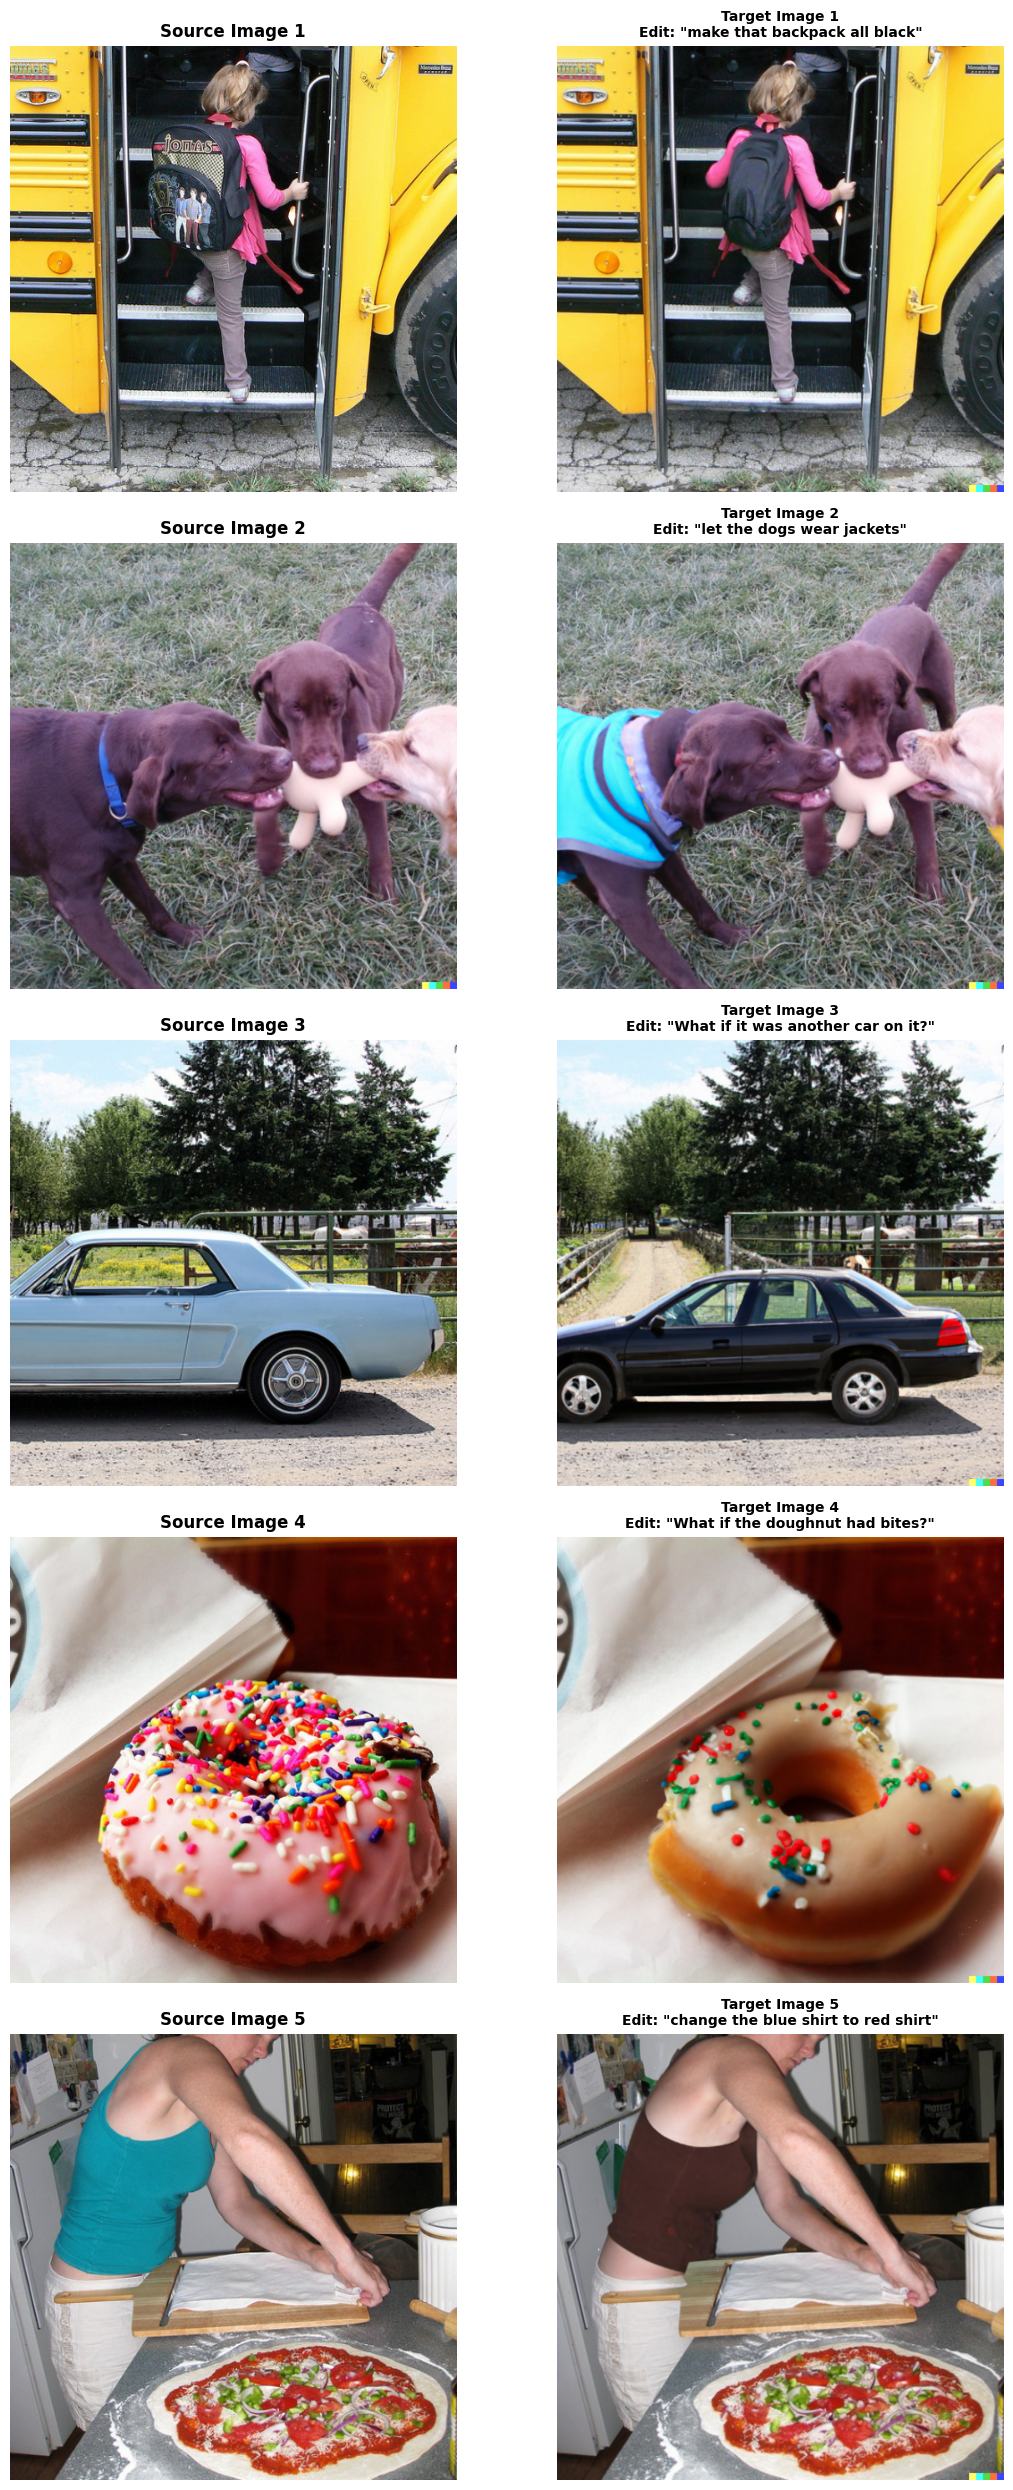


SAMPLE DETAILS

Sample 1:
  ID: train_13
  Instruction: "make that backpack all black"
  Turn index: 1
  Image ID: 298692

Sample 2:
  ID: train_17
  Instruction: "let the dogs wear jackets"
  Turn index: 2
  Image ID: 275542

Sample 3:
  ID: train_23
  Instruction: "What if it was another car on it?"
  Turn index: 1
  Image ID: 173530

Sample 4:
  ID: train_45
  Instruction: "What if the doughnut had bites?"
  Turn index: 1
  Image ID: 383706

Sample 5:
  ID: train_62
  Instruction: "change the blue shirt to red shirt"
  Turn index: 1
  Image ID: 328270

✓ Visualization complete!


In [17]:
"""
Visualize specific MagicBrush fashion samples
Downloads ONLY the selected samples' images
"""

import json
import matplotlib.pyplot as plt
from PIL import Image

def visualize_fashion_samples(num_samples=5):
    """
    Download and visualize specific fashion samples

    Args:
        num_samples: Number of samples to visualize (default 5)
    """
    print("="*60)
    print("MAGICBRUSH FASHION SAMPLE VISUALIZER")
    print("="*60)

    # Load the fashion samples metadata
    print("\n📂 Loading fashion samples metadata...")
    try:
        with open('fashion_samples.json', 'r') as f:
            fashion_samples = json.load(f)
        print(f"✓ Loaded {len(fashion_samples)} fashion samples")
    except FileNotFoundError:
        print("❌ fashion_samples.json not found!")
        print("   Run the loader script first")
        return

    if len(fashion_samples) == 0:
        print("❌ No fashion samples to visualize")
        return

    # Select samples to visualize
    num_samples = min(num_samples, len(fashion_samples))
    selected_samples = fashion_samples[:num_samples]

    print(f"\n📥 Downloading images for {num_samples} samples...")
    print("⚠️  This will download ~2-5 MB")

    # Now load the full dataset to get images for these specific samples
    try:
        from datasets import load_dataset

        print("   Loading full dataset (this may take a moment)...")
        dataset = load_dataset("osunlp/MagicBrush", split='train')
        print(f"   ✓ Dataset loaded ({len(dataset)} total samples)")

        # Download images for selected samples
        downloaded_samples = []

        for i, sample in enumerate(selected_samples):
            # Extract the index from the sample ID (format: "train_123")
            idx = int(sample['id'].split('_')[1])

            if idx < len(dataset):
                print(f"   Downloading sample {i+1}/{num_samples} (index {idx})...")

                full_sample = dataset[idx]

                downloaded_samples.append({
                    'id': sample['id'],
                    'instruction': sample['instruction'],
                    'source_img': full_sample['source_img'],
                    'target_img': full_sample['target_img'],
                    'img_id': sample.get('img_id', ''),
                    'turn_index': sample.get('turn_index', 0)
                })

        print(f"\n✓ Downloaded {len(downloaded_samples)} samples")

    except Exception as e:
        print(f"❌ Error loading images: {e}")
        return

    # Create visualization
    print("\n🖼️  Creating visualization...")

    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 5*num_samples))

    # Handle single sample case
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, sample in enumerate(downloaded_samples):
        # Source image (left)
        axes[i, 0].imshow(sample['source_img'])
        axes[i, 0].set_title(f"Source Image {i+1}", fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')

        # Target image (right)
        axes[i, 1].imshow(sample['target_img'])

        # Wrap instruction text
        instruction = sample['instruction']
        if len(instruction) > 60:
            # Split into multiple lines
            words = instruction.split()
            lines = []
            current_line = []
            for word in words:
                current_line.append(word)
                if len(' '.join(current_line)) > 60:
                    lines.append(' '.join(current_line[:-1]))
                    current_line = [word]
            lines.append(' '.join(current_line))
            instruction = '\n'.join(lines)

        axes[i, 1].set_title(
            f"Target Image {i+1}\nEdit: \"{instruction}\"",
            fontsize=10,
            fontweight='bold'
        )
        axes[i, 1].axis('off')

    plt.tight_layout()

    # Save visualization
    output_path = 'fashion_sample_visualization.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved visualization to: {output_path}")

    # Show the plot
    plt.show()

    # Print sample details
    print("\n" + "="*60)
    print("SAMPLE DETAILS")
    print("="*60)

    for i, sample in enumerate(downloaded_samples):
        print(f"\nSample {i+1}:")
        print(f"  ID: {sample['id']}")
        print(f"  Instruction: \"{sample['instruction']}\"")
        print(f"  Turn index: {sample['turn_index']}")
        print(f"  Image ID: {sample['img_id']}")

    print("\n" + "="*60)
    print("✓ Visualization complete!")
    print("="*60)


def visualize_specific_samples(sample_indices):
    """
    Visualize specific samples by their index in fashion_samples.json

    Args:
        sample_indices: List of indices to visualize (e.g., [0, 5, 10, 20, 50])
    """
    print("="*60)
    print("VISUALIZING SPECIFIC SAMPLES")
    print("="*60)

    # Load metadata
    with open('fashion_samples.json', 'r') as f:
        fashion_samples = json.load(f)

    selected = [fashion_samples[i] for i in sample_indices if i < len(fashion_samples)]

    print(f"\n📋 Selected {len(selected)} samples:")
    for i, sample in enumerate(selected):
        print(f"   {sample_indices[i]}: \"{sample['instruction']}\"")

    # Load full dataset
    from datasets import load_dataset
    dataset = load_dataset("osunlp/MagicBrush", split='train')

    # Download images
    downloaded = []
    for sample in selected:
        idx = int(sample['id'].split('_')[1])
        if idx < len(dataset):
            full_sample = dataset[idx]
            downloaded.append({
                'instruction': sample['instruction'],
                'source_img': full_sample['source_img'],
                'target_img': full_sample['target_img']
            })

    # Visualize
    num_samples = len(downloaded)
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 5*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, sample in enumerate(downloaded):
        axes[i, 0].imshow(sample['source_img'])
        axes[i, 0].set_title(f"Source {i+1}", fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(sample['target_img'])
        axes[i, 1].set_title(f"Target {i+1}: \"{sample['instruction']}\"", fontsize=10)
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig('specific_samples_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Saved: specific_samples_visualization.png")


# Main execution
if __name__ == "__main__":
    print("MAGICBRUSH FASHION VISUALIZER")
    print("="*60)
    print("\nOptions:")
    print("1. visualize_fashion_samples(5)  - View first 5 samples")
    print("2. visualize_specific_samples([0, 10, 20, 30, 40])  - View specific indices")
    print("\nDefault: Visualizing first 5 samples...")
    print()

    visualize_fashion_samples(num_samples=5)

In [1]:
"""
SwiftEdit Setup and LoRA Fine-tuning Preparation
Load SwiftEdit, generate sample edits, and prepare for fashion domain fine-tuning
"""

import os
import torch
from PIL import Image
import matplotlib.pyplot as plt

# ============================================================================
# PART 1: INSTALLATION & SETUP
# ============================================================================

def setup_swiftedit():
    """
    Install SwiftEdit and dependencies
    Run this first in a Colab cell
    """
    print("="*60)
    print("SWIFTEDIT INSTALLATION")
    print("="*60)

    # Check GPU
    if torch.cuda.is_available():
        print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
        print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    else:
        print("⚠️  No GPU detected - this will be slow!")

    print("\n📦 Installing SwiftEdit...")

    # Installation commands (run these in separate cells)
    install_commands = """
    # Cell 1: Clone repository
    !git clone https://github.com/Qualcomm-AI-research/SwiftEdit.git
    %cd SwiftEdit

    # Cell 2: Install dependencies
    !pip install -q diffusers transformers accelerate safetensors
    !pip install -q peft  # For LoRA
    !pip install -q omegaconf einops

    # Cell 3: Download model weights
    # SwiftEdit weights are released via GitHub releases
    # Check: https://github.com/Qualcomm-AI-research/SwiftEdit/releases
    """

    print(install_commands)

    return install_commands


# ============================================================================
# PART 2: LOAD SWIFTEDIT MODEL
# ============================================================================

class SwiftEditLoader:
    """
    Load and use SwiftEdit for image editing
    """

    def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        self.model = None
        self.pipe = None

    def load_model(self, checkpoint_path=None):
        """
        Load SwiftEdit model

        Args:
            checkpoint_path: Path to SwiftEdit checkpoint (download from releases)
        """
        print("="*60)
        print("LOADING SWIFTEDIT MODEL")
        print("="*60)

        try:
            # Import SwiftEdit modules
            # Note: The actual import depends on SwiftEdit's code structure
            # This is a template - adjust based on actual repository structure

            from diffusers import AutoPipelineForText2Image
            from transformers import CLIPTextModel, CLIPTokenizer

            print("📥 Loading SwiftBrushv2 (base model)...")

            # SwiftEdit is built on SwiftBrushv2
            # Load the base model first
            self.pipe = AutoPipelineForText2Image.from_pretrained(
                "ByteDance/SDXL-Lightning",  # Or SwiftBrushv2 if available on HF
                torch_dtype=torch.float16,
                variant="fp16"
            ).to(self.device)

            print("✓ Base model loaded")

            # If you have SwiftEdit checkpoint, load it here
            if checkpoint_path and os.path.exists(checkpoint_path):
                print(f"📥 Loading SwiftEdit checkpoint from {checkpoint_path}...")
                # Load checkpoint logic here
                # state_dict = torch.load(checkpoint_path)
                # self.model.load_state_dict(state_dict)
                print("✓ SwiftEdit checkpoint loaded")
            else:
                print("⚠️  No SwiftEdit checkpoint provided")
                print("   Using base SwiftBrushv2 model")
                print("   Download checkpoint from:")
                print("   https://github.com/Qualcomm-AI-research/SwiftEdit/releases")

            return True

        except Exception as e:
            print(f"❌ Error loading model: {e}")
            print("\n💡 Make sure you:")
            print("   1. Cloned SwiftEdit repository")
            print("   2. Downloaded model weights")
            print("   3. Installed all dependencies")
            return False

    def edit_image(self,
                   source_image_path,
                   source_prompt,
                   edit_prompt,
                   num_inference_steps=1,  # SwiftEdit uses 1 step!
                   guidance_scale=7.5):
        """
        Edit an image using SwiftEdit

        Args:
            source_image_path: Path to source image
            source_prompt: Description of source image
            edit_prompt: Edit instruction
            num_inference_steps: Number of steps (1 for SwiftEdit)
            guidance_scale: Guidance scale

        Returns:
            Edited image
        """
        print(f"\n🎨 Editing image...")
        print(f"   Source: {source_prompt}")
        print(f"   Edit: {edit_prompt}")

        # Load source image
        source_image = Image.open(source_image_path).convert("RGB")

        # For now, using basic text-to-image
        # Actual SwiftEdit has inversion + editing pipeline
        # This is a placeholder - actual code depends on SwiftEdit API

        edited_image = self.pipe(
            prompt=edit_prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
        ).images[0]

        print("✓ Edit complete")

        return edited_image


# ============================================================================
# PART 3: PREPARE FOR LORA FINE-TUNING
# ============================================================================

class LoRAFineTuner:
    """
    Prepare SwiftEdit for LoRA fine-tuning on fashion data
    """

    def __init__(self, model):
        self.model = model
        self.lora_config = None

    def setup_lora(self,
                   rank=8,
                   alpha=16,
                   target_modules=None):
        """
        Add LoRA adapters to SwiftEdit model

        Args:
            rank: LoRA rank (lower = fewer parameters)
            alpha: LoRA alpha (scaling factor)
            target_modules: Which modules to add LoRA to
        """
        print("="*60)
        print("SETTING UP LORA FOR FINE-TUNING")
        print("="*60)

        from peft import LoraConfig, get_peft_model

        # Default target modules for diffusion models
        if target_modules is None:
            target_modules = [
                "to_q",  # Query projection in attention
                "to_k",  # Key projection
                "to_v",  # Value projection
                "to_out.0",  # Output projection
            ]

        print(f"📊 LoRA Configuration:")
        print(f"   Rank: {rank}")
        print(f"   Alpha: {alpha}")
        print(f"   Target modules: {target_modules}")

        # Create LoRA config
        self.lora_config = LoraConfig(
            r=rank,
            lora_alpha=alpha,
            target_modules=target_modules,
            lora_dropout=0.1,
            bias="none",
        )

        # Apply LoRA to model
        # Note: This depends on SwiftEdit's model structure
        # For diffusion models, apply to UNet

        # Example (adjust based on actual model structure):
        # if hasattr(self.model, 'unet'):
        #     self.model.unet = get_peft_model(self.model.unet, self.lora_config)

        print("✓ LoRA adapters added")

        # Count trainable parameters
        trainable_params = 0
        all_params = 0

        # for param in self.model.parameters():
        #     all_params += param.numel()
        #     if param.requires_grad:
        #         trainable_params += param.numel()

        # print(f"\n📈 Model Parameters:")
        # print(f"   Total: {all_params:,}")
        # print(f"   Trainable (LoRA): {trainable_params:,}")
        # print(f"   Trainable ratio: {trainable_params/all_params*100:.2f}%")

        return self.lora_config

    def prepare_training_data(self, fashion_samples):
        """
        Prepare fashion dataset for training

        Args:
            fashion_samples: List of fashion samples from MagicBrush

        Returns:
            Training dataset
        """
        print("\n📊 Preparing training dataset...")

        from torch.utils.data import Dataset

        class FashionEditDataset(Dataset):
            def __init__(self, samples):
                self.samples = samples

            def __len__(self):
                return len(self.samples)

            def __getitem__(self, idx):
                sample = self.samples[idx]

                # For SwiftEdit, you need:
                # 1. Source image
                # 2. Source prompt
                # 3. Edit instruction
                # 4. Target image (edited)

                return {
                    'instruction': sample['instruction'],
                    'img_id': sample.get('img_id', ''),
                    # Add image loading logic here
                }

        dataset = FashionEditDataset(fashion_samples)

        print(f"✓ Dataset ready: {len(dataset)} samples")

        return dataset

    def get_training_config(self):
        """
        Get recommended training configuration
        """
        config = {
            'learning_rate': 1e-5,  # Conservative for LoRA
            'batch_size': 1,  # SwiftEdit paper uses batch size 1
            'num_epochs': 3,
            'gradient_accumulation_steps': 4,
            'mixed_precision': 'fp16',
            'optimizer': 'adam',
            'weight_decay': 1e-4,
            'warmup_steps': 100,
            'save_steps': 500,
            'eval_steps': 500,
        }

        print("\n⚙️  Recommended Training Config:")
        for key, value in config.items():
            print(f"   {key}: {value}")

        return config


# ============================================================================
# PART 4: DEMO USAGE
# ============================================================================

def demo_swiftedit():
    """
    Demo: Load SwiftEdit and generate sample edits
    """
    print("="*60)
    print("SWIFTEDIT DEMO")
    print("="*60)

    # Initialize loader
    loader = SwiftEditLoader()

    # Load model
    success = loader.load_model()

    if not success:
        print("\n❌ Model loading failed")
        print("   Follow setup instructions above")
        return

    # Example edit (you'll need actual images)
    # edited = loader.edit_image(
    #     source_image_path="path/to/fashion/image.jpg",
    #     source_prompt="A woman wearing a blue dress",
    #     edit_prompt="A woman wearing a red dress"
    # )

    print("\n✓ Demo complete!")
    print("\n📋 Next Steps:")
    print("   1. Download SwiftEdit checkpoint")
    print("   2. Test with your fashion images")
    print("   3. Set up LoRA for fine-tuning")
    print("   4. Train on MagicBrush fashion data")


def demo_lora_setup():
    """
    Demo: Set up LoRA for fine-tuning
    """
    print("="*60)
    print("LORA FINE-TUNING SETUP DEMO")
    print("="*60)

    # This is a template - actual implementation depends on loaded model

    print("\n📝 LoRA Fine-tuning Pipeline:")
    print("   1. Load SwiftEdit model")
    print("   2. Add LoRA adapters to cross-attention layers")
    print("   3. Freeze base model weights")
    print("   4. Train only LoRA parameters on fashion data")
    print("   5. Save LoRA adapters")

    print("\n💾 LoRA Benefits:")
    print("   - Only ~1-5% of parameters are trainable")
    print("   - Faster training")
    print("   - Less memory usage")
    print("   - Easy to merge/swap adapters")

    # Example setup
    # model = load_swiftedit()
    # tuner = LoRAFineTuner(model)
    # tuner.setup_lora(rank=8, alpha=16)
    # dataset = tuner.prepare_training_data(fashion_samples)
    # config = tuner.get_training_config()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("SWIFTEDIT + LORA SETUP GUIDE")
    print("="*60)

    print("\n🎯 Your Project Goal:")
    print("   Fine-tune SwiftEdit for fashion domain using LoRA")

    print("\n📋 Step-by-Step Guide:")
    print("   1. Install SwiftEdit (run setup_swiftedit())")
    print("   2. Download model checkpoints")
    print("   3. Load SwiftEdit and test edits")
    print("   4. Add LoRA adapters")
    print("   5. Train on MagicBrush fashion samples")

    print("\n" + "="*60)
    print("RUN THESE FUNCTIONS IN ORDER:")
    print("="*60)
    print("1. setup_swiftedit()       # Install everything")
    print("2. demo_swiftedit()        # Test model loading")
    print("3. demo_lora_setup()       # Prepare for training")


SWIFTEDIT + LORA SETUP GUIDE

🎯 Your Project Goal:
   Fine-tune SwiftEdit for fashion domain using LoRA

📋 Step-by-Step Guide:
   1. Install SwiftEdit (run setup_swiftedit())
   2. Download model checkpoints
   3. Load SwiftEdit and test edits
   4. Add LoRA adapters
   5. Train on MagicBrush fashion samples

RUN THESE FUNCTIONS IN ORDER:
1. setup_swiftedit()       # Install everything
2. demo_swiftedit()        # Test model loading
3. demo_lora_setup()       # Prepare for training


In [4]:
    # Uncomment to run demos
    #setup_swiftedit()
    demo_swiftedit()
    # demo_lora_setup()

SWIFTEDIT DEMO
LOADING SWIFTEDIT MODEL
📥 Loading SwiftBrushv2 (base model)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


❌ Error loading model: ByteDance/SDXL-Lightning does not appear to have a file named model_index.json.

💡 Make sure you:
   1. Cloned SwiftEdit repository
   2. Downloaded model weights
   3. Installed all dependencies

❌ Model loading failed
   Follow setup instructions above
